In [2]:
import sys
sys.path.insert(0, '/home/yw440/MXGPY/mxgpy')
sys.path.insert(0, '/home/yw440/MyRGPs/')
import os
os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'

import scipy.io
from pylab import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

from mxgpy.rgp.rgp import RGP 
from mxgpy.kernel.rbf import RBF
import mxnet as mx
ctx = mx.gpu()
mx.Context.default_ctx = ctx

from mxgpy.util import positive_transform_reverse_numpy
import helper

 /anaconda/envs/py35/lib/python3.5/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning:OpenSSL.rand is deprecated - you should use os.urandom instead
 /anaconda/envs/py35/lib/python3.5/site-packages/mxnet/context.py:144: DeprecationWarning:Context.default_ctx has been deprecated. Please use Context.current_context() instead. Please use test_utils.set_default_context to set a default context


In [3]:
train_motions = ['01', '02', '03', '04']
test_motions = ['05', '06', '07', '08']
subject = '35'
m1 = GPy.util.datasets.cmu_mocap(subject, train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
y_train = helper.extract_independent_bones(m1['Y'], m1['lbls']) # list of lists of arrays
y_test = helper.extract_independent_bones(m1['Ytest'], m1['lblstest'])


y_train_list, y_train_mean_list, y_train_std_list = [],[],[]
for item in y_train:
    out, mean, std = helper.normalise_data(item)
    y_train_list.append(out)
    y_train_mean_list.append(mean)
    y_train_std_list.append(std)
    
    
y_test_list, y_test_mean_list, y_test_std_list = [], [], []
for item in y_test:
    out, mean, std = helper.normalise_data(item)
    y_test_list.append(out)
    y_test_mean_list.append(mean)
    y_test_std_list.append(std)
    
y_train = helper.reshape(y_train_list)
y_train_mean = helper.reshape(y_train_mean_list)
y_train_std = helper.reshape(y_train_std_list)

y_test = helper.reshape(y_test_list)
y_test_mean = helper.reshape(y_test_mean_list)
y_test_std = helper.reshape(y_test_std_list)


# No Control

- HD is one, the results is ok. Test when HD is 2?
- GOLF has very low training loss with 3 dimensional hidden layer. Test if the result is transferrable.

In [3]:
## --- Training --- ##
## Initialize model
YD = np.shape(y_train[0])[1]
HD = 5
win_out = 20

m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=100,
        kernels=[RBF(win_out*HD, ARD=True, dtype=np.float64, name='rbf0'), 
                 RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
        nSamples=5, q_hidden_units=[200,200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
    
## Initialize parameters
m.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*HD,))*3,np.float64))
m.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones(((win_out+1)*HD+win_out*YD,))*20,np.float64))
m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([1e-4]),np.float64))
m.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([np.var(np.vstack(y_train))*0.01]),np.float64))    

## Train model
m.optimize(Y=y_train, max_iters=300, step_rate=0.03)
m.optimize(Y=y_train, max_iters=500, step_rate=0.02)
m.optimize(Y=y_train, max_iters=1500, step_rate=0.01)
m.optimize(Y=y_train, max_iters=1500, step_rate=0.005)
    
## Save model
m.save_params('./models/no_control_walk5') 

100%|██████████| 1500/1500 [1:51:36<00:00,  4.46s/it, loss=3.63e+04]


- HD=1: FINAL LOSS: 1.32e4
- HD=2: FINAL LOSS:
- HD=3: FINAL LOSS:
- HD=5: FINAL LOSS: 3.63e4

In [5]:
m.optimize(Y=y_train, max_iters=1500, step_rate=0.01)
m.optimize(Y=y_train, max_iters=1000, step_rate=0.005)

100%|██████████| 1000/1000 [1:02:18<00:00,  3.74s/it, loss=1.32e+04]


In [10]:
## Save model
m.save_params('./models/no_control_walk')

In [ ]:
m.show_params(RBF_param=False)

In [5]:
## --- testing --- ##
win_out = 20
HD = 1

num_test_seq = np.shape(y_test_list)[1]
y_pds = [[] for _ in range(num_test_seq)]
u_test_list = []
for seq in range(num_test_seq):
    y_pds[seq] = test_run('no_control_walk1', seq, win_out, y_test, HD, MEAN_PRED=True, with_control=False) # output array
    
pds = [[] for _ in range(num_test_seq)]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, y_test_mean[seq], y_test_std[seq])
    
### Write .amc motion files
for seq, pd in enumerate(pds):
    filename = './predictions/no_control_walk1_seq'+str(seq)
    helper.write_amc(pd, filename)
    break

Observationa dimension: 62
Observationa dimension: 62
Observationa dimension: 62
Observationa dimension: 62


In [62]:
## HD=1
print(helper.compute_MSE(y_test_list, y_pds))

[0.3371850436394939, 0.24491366027018882, 0.3080196363255944, 0.31134790836960885]


In [15]:
## HD=2
print(helper.compute_MSE(y_test_list, y_pds))

[0.36676619493805546, 0.23468293250338018, 0.3035028742836042, 0.3154122850865449]


In [9]:
## HD=3
print(helper.compute_MSE(y_test_list, y_pds))

[0.3613914249126346, 0.2588045675943434, 0.3061900945608879, 0.3329974933002684]


In [6]:
## HD=5
print(helper.compute_MSE(y_test_list, y_pds))

[0.4011187096750974, 0.3246254955857652, 0.3939754036206437, 0.29353320784139886]


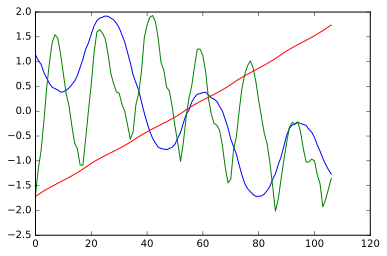

In [12]:
# original
plot(y_test[0][:,:3])

In [42]:
def plot_dim(dim, data_in, win_out, HD, model, path, Save=True):
    YD = data_in.shape[-1]
    m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=100,
                kernels=[RBF(win_out*HD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True,dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200, 200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
    m.load_params(path)
    #data_in[seq].shape[0]-win_out
    y_pd = m.freerun(data_in.shape[0]-win_out, init_X=data_in[:win_out,:], mean_predict=False, nSamples=100)
    print(np.shape(y_pd))
    pred_mean, = plot(y_pd[:,:,dim].mean(0),'b', label='prediction-mean')
    pred_var, = plot(y_pd[:,:,dim].mean(0)-y_pd[:,:,dim].std(0)*2, 'b--', label='prediction-variance')
    plot(y_pd[:,:,dim].mean(0)+y_pd[:,:,dim].std(0)*2, 'b--')
    ground_truth, =plot(data_in[:,dim],'r',label='ground-truth')
    
    ylabel('Normalised Value')
    xlabel('Samples')
    title(model+': Dimension-'+str(dim+1))
    legend(handles=[pred_mean, pred_var, ground_truth], prop={'size':7})
    
    if Save:
        savefig('latent'+model+str(dim))

(100, 107, 62)


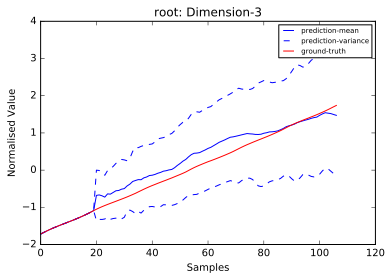

In [43]:
## prediction
plot_dim(2, y_test[0], 20, HD=1, model='root', path='./models/no_control_walk1')

(100, 107, 62)


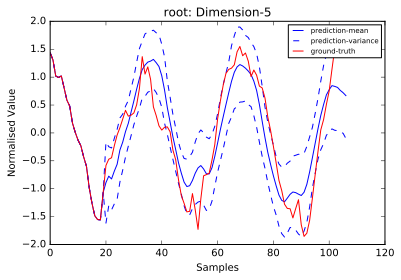

In [44]:
## prediction
plot_dim(4, y_test[0], 20, HD=1, model='root', path='./models/no_control_walk1')

(100, 107, 62)


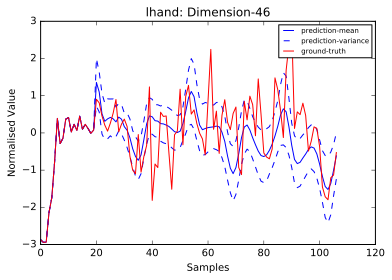

In [45]:
## prediction
plot_dim(45, y_test[0], 20, HD=1, model='lhand', path='./models/no_control_walk1')

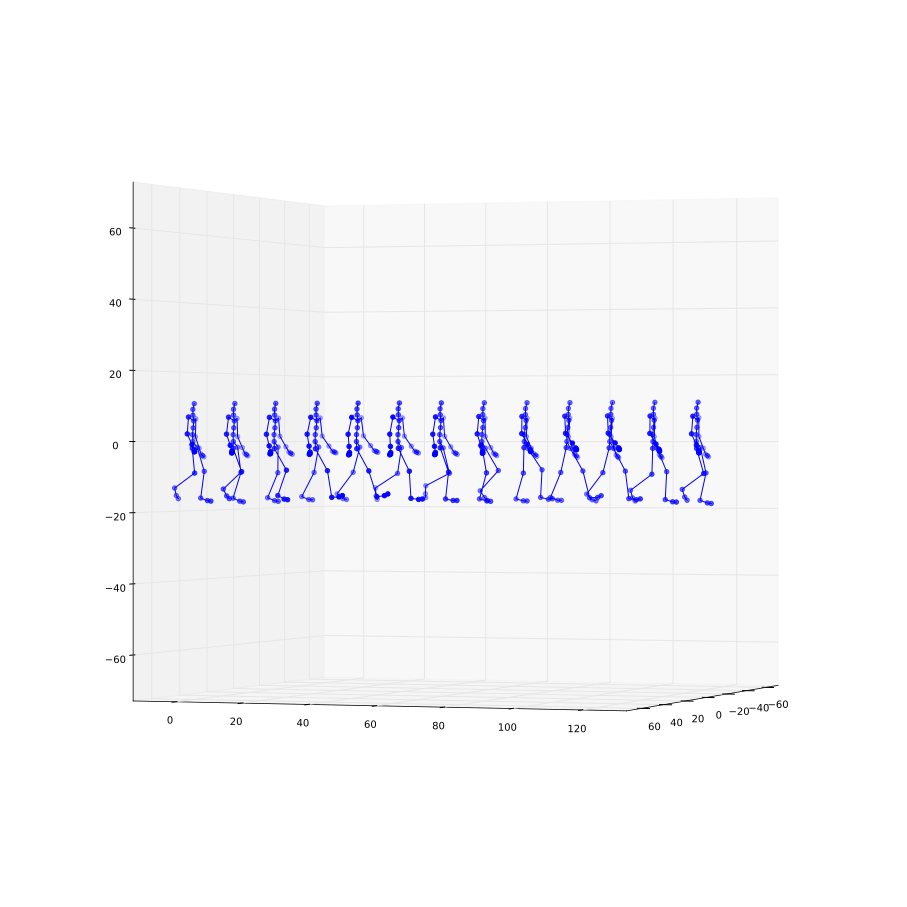

In [8]:
helper.save_trail(y_pds[0][:,3:], y_test_mean[0][3:], y_test_std[0][3:], m1['skel'], "no_control_walk5")

In [38]:
idxs = [6, 3, 1, 2, 1, 3, 1, 2, 1,
            3, 3, 3, 3, 3, 3, 
            2, 3, 1, 1, 2]#, 1, 2, 
#             2, 3, 1, 1, 2, 1, 2 ]
sum(idxs)

47

# Control

In [39]:
print(np.shape(y_train[1]), np.shape(u_train[1]))

(102, 62) (102, 6)


In [5]:
u_train = [helper.compute_delta(x[:,:3]) for x in y_train]
for i, item in enumerate(u_train):
    u_train[i] = np.array(item)

In [7]:
np.shape(u_train[0])

(90, 3)

In [22]:
## --- Training --- ##
## Initialize model
u_train = [helper.compute_delta(x[:,:6]) for x in y_train]
for i, item in enumerate(u_train):
    u_train[i] = np.array(item)

YD = np.shape(y_train[0])[-1]
UD = np.shape(u_train[0])[-1]
HD = 2

win_in = 20
win_out = 20

m = RGP(wins=[win_out, win_out], with_control=True, X_dims=[HD, YD], U_dim=UD, U_win=win_in, num_inducing=100,
        kernels=[RBF(win_out*HD+win_in*UD, ARD=True, dtype=np.float64, name='rbf0'), 
                 RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
        nSamples=5, q_hidden_units=[200,400,200], h0_hidden_units=[200,400,200], ctx=ctx, dtype=np.float64)
    
## Initialize parameters
m.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*HD+win_in*UD,))*3,np.float64))
m.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones(((win_out+1)*HD+win_out*YD,))*20,np.float64))
m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([1e-4]),np.float64))
m.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([np.var(np.vstack(y_train))*0.01]),np.float64))    

    
## Train model
m.optimize(Y=y_train, U=u_train, max_iters=300, step_rate=0.03)
m.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.02)
m.optimize(Y=y_train, U=u_train, max_iters=1000, step_rate=0.01)
    
## Save model
m.save_params('./models/control_walk2') 

100%|██████████| 1000/1000 [1:02:07<00:00,  3.73s/it, loss=1.46e+04]


In [23]:
def test_run(model, seq, win_out,  test_data, HD, win_in=None,control_signal=None, MEAN_PRED=True, with_control=True):
    if with_control:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        UD = np.shape(control_signal[0])[-1] ; print('Control signal dimension:', UD)
        
        m = RGP(wins=[win_out, win_out], with_control=True, X_dims=[HD, YD], U_dim=UD, U_win=win_in, num_inducing=100,
                kernels=[RBF(win_out*HD+win_in*UD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200,200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
        
        m.load_params('./models/'+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:],
                         U=control_signal[seq], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    else:
        YD = np.shape(test_data[0])[-1]; print('Observationa dimension:', YD)
        
    
        m = RGP(wins=[win_out, win_out], with_control=False, X_dims=[HD, YD], num_inducing=100,
                kernels=[RBF(win_out*HD, ARD=True, dtype=np.float64, name='rbf0'), 
                         RBF((win_out+1)*HD+win_out*YD, ARD=True,dtype=np.float64, name='rbf1')],
                nSamples=5, q_hidden_units=[200, 200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
        m.load_params('./models/'+model)
    
        y_pd = m.freerun(test_data[seq].shape[0]-win_out, init_X=test_data[seq][:win_out,:], mean_predict=False, nSamples=100)
    
        y_pd_mean = y_pd.mean(0) # the first dimention of the matrix is number of samples
        y_pd_std = y_pd.std(0)
    
    if MEAN_PRED:
        return y_pd_mean
    else:
        return y_pd_mean + y_pd_std*np.random.normal(0,0.5,size=(y_pd_mean.shape[0], y_pd_mean.shape[1]))

In [25]:
## --- testing --- ##
u_test = [helper.compute_delta(x[:,:6]) for x in y_test]
for i, item in enumerate(u_test):
    u_test[i] = np.array(item)

win_in = 20
win_out = 20
HD=2

num_test_seq = np.shape(y_test_list)[1]

y_pds = [[] for _ in range(num_test_seq)]
for seq, test_data in enumerate(y_test):
    y_pds[seq] = test_run('control_walk2', seq, win_out, y_test, HD, win_in, control_signal=u_test, 
                          MEAN_PRED=True, with_control=True) #output array
    
pds = [[] for _ in range(num_test_seq)]
for seq, preds in enumerate(y_pds):
    pds[seq] = helper.reverse_normalise_data(preds, y_test_mean[seq], y_test_std[seq])
    
### Write .amc motion files
for seq, pd in enumerate(pds):
    filename = './predictions/control_walk2_seq'+str(seq)
    helper.write_amc(pd, filename)
    break

Observationa dimension: 62
Control signal dimension: 6
Observationa dimension: 62
Control signal dimension: 6
Observationa dimension: 62
Control signal dimension: 6
Observationa dimension: 62
Control signal dimension: 6


In [26]:
print(helper.compute_MSE(y_test_list, y_pds))

[0.3676712812618032, 0.25713231894072136, 0.3141805553465638, 0.3522548984387206]


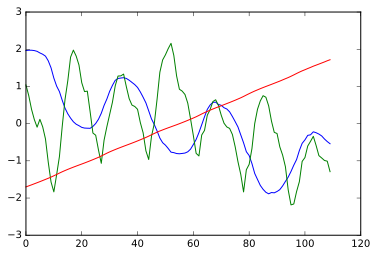

In [20]:
plot(y_test[1][:,:3])

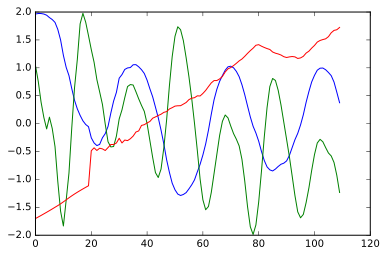

In [27]:
plot(y_pds[1][:,:3])

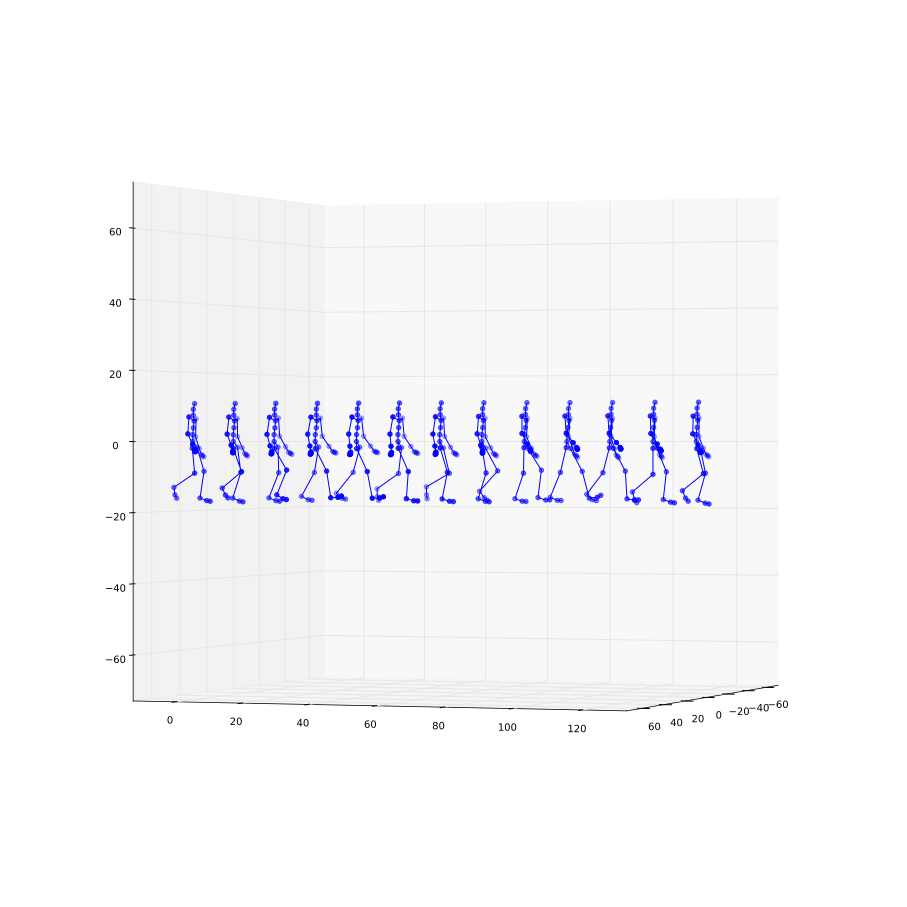

In [28]:
helper.save_trail(y_pds[0][:,3:], y_test_mean[0][3:], y_test_std[0][3:], m1['skel'], "control_walk2")

# Hidden layer only

In [ ]:
## --- Training --- ##
## Initialize model
u_train = helper.compute_delta(y_train_dict["root"])

YD = np.shape(y_train[0])[-1]
UD = np.shape(u_train[0])[-1]
HD = 1

win_in = 20
win_out = 20

m = RGP(wins=[win_out, 0], with_control=True, X_dims=[HD, YD], U_dim=UD, U_win=win_in, num_inducing=100,
        kernels=[RBF(win_out*HD+win_in*UD, ARD=True, dtype=np.float64, name='rbf0'), 
                 RBF((win_out+1)*HD+win_out*YD, ARD=True, dtype=np.float64, name='rbf1')],
        nSamples=5, q_hidden_units=[200,200], h0_hidden_units=[200,200], ctx=ctx, dtype=np.float64)
    
# ## Initialize parameters
# m.collect_params()['rbf0_variance'].set_data(positive_transform_reverse_numpy(np.array([3.]), np.float64))
# m.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*1,))*3,np.float64))
# m.collect_params()['rbf1_variance'].set_data(positive_transform_reverse_numpy(np.array([3.]), np.float64))
# m.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*D+win_out*1,))*3,np.float64))
# m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.00001]),np.float64))
# m.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([0.00001]),np.float64))
## Initialize parameters
m.collect_params()['rbf0_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones((win_out*HD,))*3,np.float64))
m.collect_params()['rbf1_lengthscale'].set_data(positive_transform_reverse_numpy(np.ones(((win_out+1)*HD+win_out*YD,))*20,np.float64))
m.collect_params()['layer_0_noise_var'].set_data(positive_transform_reverse_numpy(np.array([1e-4]),np.float64))
m.collect_params()['layer_1_noise_var'].set_data(positive_transform_reverse_numpy(np.array([np.var(np.vstack(y_train))*0.01]),np.float64))    

    
## Train model
# m.collect_params()['layer_0_noise_var'].grad_req = 'null' # write new noise variance to a single value
m.optimize(Y=y_train, U=u_train, max_iters=200, step_rate=0.02)
# m.collect_params()['layer_0_noise_var'].grad_req = 'write' # write new noise variance to a single value
m.optimize(Y=y_train, U=u_train, max_iters=500, step_rate=0.015)
m.optimize(Y=y_train, U=u_train, max_iters=1000, step_rate=0.01)
m.optimize(Y=y_train, U=u_train, max_iters=1000, step_rate=0.005)
    
## Save model
m.save_params('./models/hidden_only_walk') 